# Generative Adversarial Network (GAN)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [241]:
def accuracy(net, dl):
    acc = 0.
    for x,t in dl:
        y = net(x)
        k = torch.argmax(y, dim=-1)
        acc += torch.sum(k==t)
    return acc.item() / len(dl.dataset)

# Dataset

In [259]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
ds_train_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            ]))

In [430]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
ds_train_full = torchvision.datasets.FashionMNIST('./fashion_files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            ]))

In [431]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
ds_test = torchvision.datasets.FashionMNIST('./fashion_files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            ]))

In [432]:
ds_train = torch.utils.data.Subset(ds_train_full, range(1024))

In [433]:
x,t = ds_train.__getitem__(0)

In [481]:
def draw(X):
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');
    if len(X.shape)==4:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

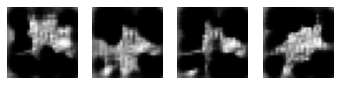

In [483]:
draw(x[:4])

In [436]:
# Batched, for training
batch_size_train = 10
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True)

In [437]:
x,t = next(iter(train_dl))
x.shape
print(t)

tensor([2, 7, 1, 7, 9, 3, 2, 2, 9, 9])


# Network

In [445]:
class gan(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = 5
        self.losses_D = []
        self.losses_G = []
        self.D = nn.Sequential(
            nn.Conv2d(1, 10, 3), nn.ReLU(),
            nn.Conv2d(10, 16, 3), nn.ReLU(),
            nn.Conv2d(16, 5, 3), nn.ReLU(),
            nn.Flatten(start_dim=1),
        )
        blah = torch.zeros((3, 1, 28, 28))
        pen_dim = self.D(blah).shape[-1]
        self.Dhead = nn.Sequential(nn.Linear(pen_dim, 1), nn.Sigmoid())
        
        self.G = nn.Sequential(
            nn.Linear(self.z_dim, pen_dim),
            nn.Unflatten(-1, (5,22,22)), nn.ReLU(),
            nn.ConvTranspose2d(5, 16, 3), nn.ReLU(),
            nn.ConvTranspose2d(16, 10, 3), nn.ReLU(),
            nn.ConvTranspose2d(10, 1, 3), nn.Sigmoid(),
        )
        self.D_loss_fcn = nn.BCELoss()
        self.G_loss_fcn = nn.BCELoss()
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        z = self.D(x)
        return self.Dhead(z).squeeze()
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.normal(torch.zeros((n,self.z_dim,)), 1.)
        return self.G(z)
            
    def learn(self, dl, epochs=10, lr=0.001):
        optim_D = torch.optim.Adam(self.D.parameters(), lr=lr)
        optim_G = torch.optim.Adam(self.G.parameters(), lr=lr/10.)
        for epoch in tqdm(range(epochs)):
            total_D_loss = 0.
            total_G_loss = 0.
            for x,t in dl:
                bs = len(t)
                
                # Generate some inputs
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.) # seeds
                x_gen = self.G(z)  # This is the FF pass of the Generator!
                
                # Concat. legit and generated samples together into 1 batch
                x_both = torch.cat((x, x_gen))
                t_both = torch.cat( ( torch.ones((bs,)), torch.zeros((bs,)) ) )
                
                # FF pass on the Discriminator
                y = self(x_both)
                
                # Discriminator loss (for both true and generated inputs)
                loss_D = self.D_loss_fcn(y, t_both)
                
                # Gradient step for Discriminator
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                # Generator loss
                # (just process the fake images made by the generator)
                # Just like creating an adversarial input, we choose the target
                # we want (t=1), and push the gradient down through the network.
                y_gen = self( self.G(z) ) # FF through both networks z->G->D->y
                loss_G = self.G_loss_fcn(y_gen, torch.ones((len(z),)))
                optim_G.zero_grad()
                loss_G.backward()
                optim_G.step()
                
                total_D_loss += loss_D.item()*len(t)/2.
                total_G_loss += loss_G.item()*len(t)
            self.losses_D.append(total_D_loss/len(dl.dataset))
            self.losses_G.append(total_G_loss/len(dl.dataset))
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

In [446]:
net = gan()

In [ ]:
net.learn(train_dl, epochs=100, lr=0.001)

 48%|████▊     | 48/100 [02:33<02:44,  3.17s/it]

In [502]:
#torch.save(net.to('cpu'), 'vae_demo.pt')
#net = torch.load('ae_demo.pt', map_location=device)
#net = torch.load('vae_demo.pt', map_location=device); net.to(device);

[0.99113125 0.89569706 0.26069757 0.58523285 0.8236608  0.551058
 0.609069   0.40214902 0.59648746 0.7381262 ]


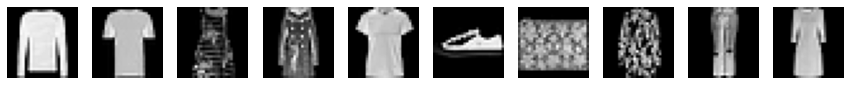

In [507]:
x,t = next(iter(train_dl))
y = net.discriminate(x)
draw(x);
print(f'{y.detach().numpy()}')

tensor([0.2386, 0.3834, 0.1091, 0.3870, 0.3260, 0.3224, 0.2134, 0.7509, 0.5996,
        0.1417], grad_fn=<SqueezeBackward0>)


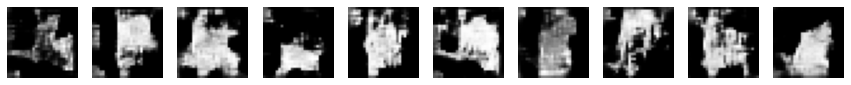

In [508]:
x = net.generate(n=10)
y = net(x)
draw(x)
print(y)

In [474]:
x.shape

torch.Size([10, 1, 28, 28])